In [1]:
%load_ext autoreload
%autoreload 2
# %cd "../deepshape"

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Import all curve reparametrization functions
from deepshape.curves import *

# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [3]:
# Analytic diffeomorphism
g = Diffeomorphism(
    lambda x: (0.5 * torch.log(20*x+1) / torch.log(21*torch.ones(1)) 
    + 0.25 * (1 + torch.tanh(20*(x-0.5)) / torch.tanh(21*torch.ones(1))))
)

# Create Curves 
c1 = Curve((
    lambda x: torch.cos(2*pi*x),
    lambda x: torch.sin(4*pi*x)
))
c2 = c1.compose(g)


# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
q, r = Qmap(c2), Qmap(c1)

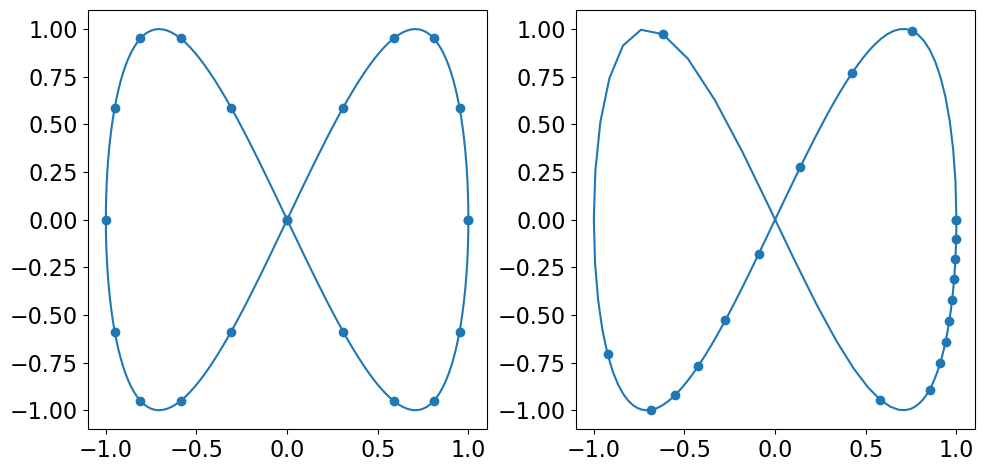

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_curve(c1, dotpoints=21, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=21, ax=plt.gca())
plt.tight_layout()
plt.show()

In [5]:
# Build network of L layers with N_l basis functions per layer
RN = ReparametrizationNetwork(5, 5, init_scale=0., layer_type=PalaisLayer)

# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=0.9, max_iter=200, line_search_fn='strong_wolfe')

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-08,
    verbose=True)

# Train with BFGS-optimizer
error = train_bfgs(q, r, RN, optimizer, scheduler=scheduler, iterations=1, log_every=1)

[Iter     1] loss: 9.44122
[Iter     2] loss: 13.55527
[Iter     3] loss: 7.66515
[Iter     4] loss: 6.93479
[Iter     5] loss: 3.63897
[Iter     6] loss: 16.30797
[Iter     7] loss: 2.75670
[Iter     8] loss: 2.90066
[Iter     9] loss: 2.34125
[Iter    10] loss: 2.04947
[Iter    11] loss: 1.10591
[Iter    12] loss: 2.19362
[Iter    13] loss: 0.44970
[Iter    14] loss: 0.12323
[Iter    15] loss: 0.06539
[Iter    16] loss: 0.06390
[Iter    17] loss: 0.06353
[Iter    18] loss: 0.06170
[Iter    19] loss: 0.05889
[Iter    20] loss: 0.05545
[Iter    21] loss: 0.05170
[Iter    22] loss: 0.05092
[Iter    23] loss: 0.05083
[Iter    24] loss: 0.05069
[Iter    25] loss: 0.05039
[Iter    26] loss: 0.04849
[Iter    27] loss: 0.04445
[Iter    28] loss: 0.04277
[Iter    29] loss: 0.04189
[Iter    30] loss: 0.04176
[Iter    31] loss: 0.04173
[Iter    32] loss: 0.04167
[Iter    33] loss: 0.04153
[Iter    34] loss: 0.04121
[Iter    35] loss: 0.04049
[Iter    36] loss: 0.03896
[Iter    37] loss: 0.03637

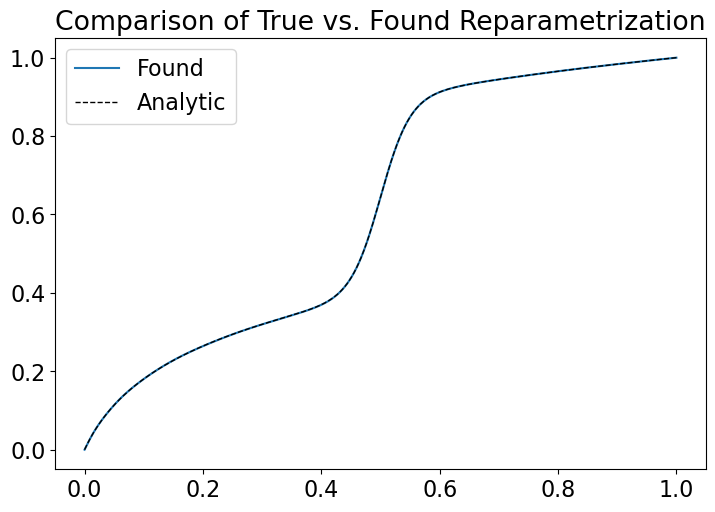

In [6]:
x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

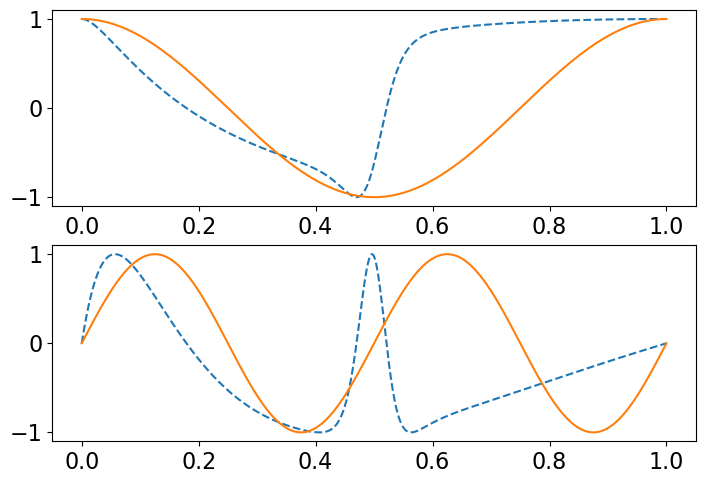

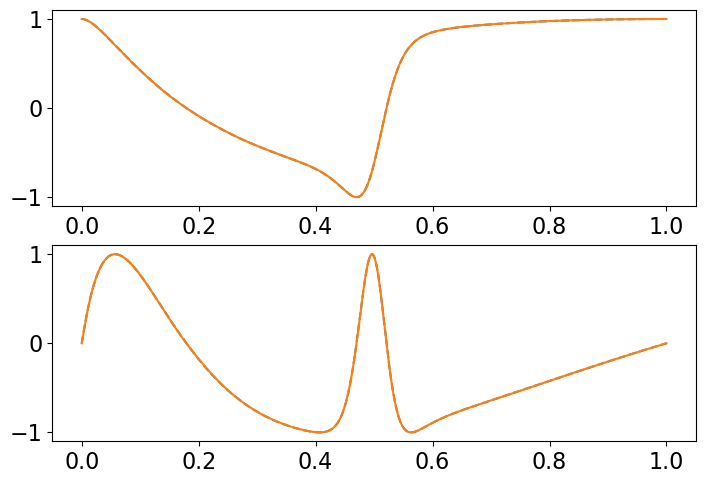

In [7]:
# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

In [8]:
torch.cuda.device_count()

1